### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit xgb as a baseline, then xgb optuna.
6. Fit DL.

### Notes

In the future, may want to use larger, publicly available dataset from Open source Asset Pricing.
But that will require much more time to do feature engineering, impute missing values etc.


In [1]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, time, math, re, warnings, random, gc, dill, optuna, pickle, shap
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option('display.max_columns', 150)
gc.enable()

In [2]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [3]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
# Functions for Optuna NNs

cv_nn_regularizer = 0.05

def create_snnn4_model_hyperpars(neurons_base=4, l1_reg_rate=0.1, l2_reg_rate=0.1):

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

def create_snnn4_model(trial):

    # hyperparameter space
    neurons_base = trial.suggest_int("neurons_base", 4, 24, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.9)
    l1_reg_rate = trial.suggest_float('l1_regularizer', 0, 0.9)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn


def create_snnn6_model_hyperpars(neurons_base=4, l1_reg_rate=0.1, l2_reg_rate=0.1):

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

def create_snnn6_model(trial):

    # hyperparameter space
    neurons_base = trial.suggest_int("neurons_base", 4, 24, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.9)
    l1_reg_rate = trial.suggest_float('l1_regularizer', 0, 0.9)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn


def objective_nn4(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn4_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=0, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        loss_train = model.evaluate(X_train, y_train, verbose=0)
        loss_val = model.evaluate(X_val_extra, y_val_extra, verbose=0)
        overfit = max(loss_val[1]-loss_train[1], 0)
        return loss_val[1] + cv_nn_regularizer*overfit
    
    
def objective_nn6(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn6_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=0, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        loss_train = model.evaluate(X_train, y_train, verbose=0)
        loss_val = model.evaluate(X_val_extra, y_val_extra, verbose=0)
        overfit = max(loss_val[1]-loss_train[1], 0)
        return loss_val[1] + cv_nn_regularizer*overfit


(28169, 41)

(3183, 41)

(3148, 41)

Number of features before transformation:  (28169, 38)
time to do feature proprocessing: 
Number of features after transformation:  (28169, 81) (3183, 81) (3135, 81) (3148, 81)
mae of a constant model 7.449410744523996
R2 of a constant model 0.0
fixed XGB train: 6.6404244439331155 0.20367387585733154
XGB val: 6.95041177187386 0.03588288720911759
XGB val extra: 7.6742518198770515 -0.025265240467944095
XGB test: 7.666935429587563 -0.011350303327938294
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.04028216208954838 44.98263454437256
XGB train: 6.654836492171592 0.19714418801403566
XGB validation: 6.658730609524091 0.11395073365489594
XGB validation extra: 7.2109727702120345 0.09519933541519099
XGB test: 7.497737377821732 0.015670922109296548
Total time for hypermarameter optimization, XGB:  48.29186701774597
        n_estimators : 821
           max_depth : 2
       learning_rate : 0.022978184975605262
    colsample_bytree : 0.14893

2022-09-23 00:04:07.545448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 00:04:07.546687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 00:04:07.547411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 00:04:07.549148: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

3673
Minimum Validation Loss: 85.0127
3329
Minimum Validation Loss: 84.5320


'Optuna NN4'

{'neurons_base': 4,
 'l2_regularizer': 0.8982720607006071,
 'l1_regularizer': 0.15361090910979086}

364.2812559604645

[4, 0.8982720607006071, 0.15361090910979086]

Time for hyperparameter optimization:  364.2916066646576 [4, 0.8982720607006071, 0.15361090910979086]


'Optuna NN6'

{'neurons_base': 16,
 'l2_regularizer': 0.15103798092855866,
 'l1_regularizer': 0.4570413571685597}

381.46557211875916

[16, 0.15103798092855866, 0.4570413571685597]

Time for hyperparameter optimization:  381.47412300109863 [16, 0.15103798092855866, 0.4570413571685597]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.154493,0.067052,0.006562,0.163225,0.05456,-0.020707,0.16998,0.071151,-0.003824,0.14052,0.043896,-0.003514,-0.0,-0.000982,-0.000893
1,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(49790, 41)

(4626, 41)

(4564, 41)

Number of features before transformation:  (49790, 38)
time to do feature proprocessing: 
Number of features after transformation:  (49790, 84) (4626, 84) (4467, 84) (4564, 84)
mae of a constant model 8.543293031215802
R2 of a constant model 0.0
fixed XGB train: 7.554798795623757 0.09287854395714357
XGB val: 8.155346117415649 0.059217993051724704
XGB val extra: 11.481561495779207 0.008107642963621764
XGB test: 10.597375953591559 0.019307149263134482
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.06484049805573822 51.58721613883972
XGB train: 7.591178027944776 0.0835461159391857
XGB validation: 8.0085812097582 0.10412380609102212
XGB validation extra: 11.04377143915742 0.09820444447955856
XGB test: 10.748917824610945 0.001780168638554569
Total time for hypermarameter optimization, XGB:  119.31062698364258
        n_estimators : 1148
           max_depth : 3
       learning_rate : 0.029430630008409394
    colsample_bytree : 0.763155

'Optuna NN4'

{'neurons_base': 24,
 'l2_regularizer': 0.19220603879503934,
 'l1_regularizer': 0.0342341858678446}

536.1029555797577

[24, 0.19220603879503934, 0.0342341858678446]

Time for hyperparameter optimization:  536.1137857437134 [24, 0.19220603879503934, 0.0342341858678446]


'Optuna NN6'

{'neurons_base': 14,
 'l2_regularizer': 0.010074630711105393,
 'l1_regularizer': 0.049681260375237304}

512.628674030304

[14, 0.010074630711105393, 0.049681260375237304]

Time for hyperparameter optimization:  512.6378264427185 [14, 0.010074630711105393, 0.049681260375237304]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.154493,0.067052,0.006562,0.163225,0.05456,-0.020707,0.16998,0.071151,-0.003824,0.14052,0.043896,-0.003514,-0.0,-0.000982,-0.000893
1,160,0.092879,0.059218,0.019307,0.083546,0.104124,0.00178,0.123592,0.16626,0.019884,0.059241,0.073432,-0.002347,0.058521,0.07053,0.011772,0.064734,0.067478,-0.001783,0.064768,0.069381,0.013801
2,220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(78777, 41)

(6776, 41)

(6725, 41)

Number of features before transformation:  (78777, 38)
time to do feature proprocessing: 
Number of features after transformation:  (78777, 85) (6776, 85) (6626, 85) (6725, 85)
mae of a constant model 7.95324650764518
R2 of a constant model 0.0
fixed XGB train: 7.461524455202487 0.06941230429324552
XGB val: 7.545997375000349 0.03352923363258653
XGB val extra: 9.067902321717076 0.03326771380649873
XGB test: 8.511134003884694 0.050883922877477894
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.6} 0.036690922773572776 60.36150026321411
XGB train: 7.37817013229899 0.09630538200710714
XGB validation: 7.335220163326625 0.09019016883303754
XGB validation extra: 8.796641457324553 0.0999231529658946
XGB test: 8.409557751581776 0.06939455058495159
Total time for hypermarameter optimization, XGB:  179.56293439865112
        n_estimators : 1192
           max_depth : 2
       learning_rate : 0.024419886166078826
    colsample_bytree : 0.58039464410

'Optuna NN4'

{'neurons_base': 8,
 'l2_regularizer': 0.33350765995508663,
 'l1_regularizer': 0.13860766358962343}

500.5272972583771

[8, 0.33350765995508663, 0.13860766358962343]

Time for hyperparameter optimization:  500.5372977256775 [8, 0.33350765995508663, 0.13860766358962343]


'Optuna NN6'

{'neurons_base': 6,
 'l2_regularizer': 0.28371010994369694,
 'l1_regularizer': 0.02463265712505747}

526.4058413505554

[6, 0.28371010994369694, 0.02463265712505747]

Time for hyperparameter optimization:  526.4139869213104 [6, 0.28371010994369694, 0.02463265712505747]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.154493,0.067052,0.006562,0.163225,0.05456,-0.020707,0.16998,0.071151,-0.003824,0.14052,0.043896,-0.003514,-0.0,-0.000982,-0.000893
1,160,0.092879,0.059218,0.019307,0.083546,0.104124,0.00178,0.123592,0.16626,0.019884,0.059241,0.073432,-0.002347,0.058521,0.07053,0.011772,0.064734,0.067478,-0.001783,0.064768,0.069381,0.013801
2,220,0.069412,0.033529,0.050884,0.096305,0.09019,0.069395,0.057841,0.054417,0.061745,0.046731,0.043672,0.056247,0.049514,0.04487,0.057143,0.04458,0.041161,0.058638,0.053382,0.041128,0.058172
3,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(78519, 41)

(7215, 41)

(7038, 41)

Number of features before transformation:  (78519, 38)
time to do feature proprocessing: 
Number of features after transformation:  (78519, 85) (7215, 85) (6886, 85) (7038, 85)
mae of a constant model 8.740440889597666
R2 of a constant model 0.0
fixed XGB train: 8.297604488211828 0.07170141058784218
XGB val: 8.869954680738646 0.05503178122139718
XGB val extra: 9.284315540402101 0.05022422667001447
XGB test: 8.41773853149442 0.0680073120103235
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.6} 0.06007307184583366 60.19013714790344
XGB train: 8.210084317488606 0.096077452118985
XGB validation: 8.506229951693221 0.14401269629057145
XGB validation extra: 8.833628830879654 0.157264683508059
XGB test: 8.235381375666007 0.1015201388443332
Total time for hypermarameter optimization, XGB:  211.18062448501587
        n_estimators : 1390
           max_depth : 3
       learning_rate : 0.027698187127620833
    colsample_bytree : 0.4609571055500522


'Optuna NN4'

{'neurons_base': 18,
 'l2_regularizer': 0.06121560129685801,
 'l1_regularizer': 0.12756324696864763}

684.106015920639

[18, 0.06121560129685801, 0.12756324696864763]

Time for hyperparameter optimization:  684.1146867275238 [18, 0.06121560129685801, 0.12756324696864763]


'Optuna NN6'

{'neurons_base': 8,
 'l2_regularizer': 0.6732083575804324,
 'l1_regularizer': 0.0006618523566765733}

503.35385394096375

[8, 0.6732083575804324, 0.0006618523566765733]

Time for hyperparameter optimization:  503.3621425628662 [8, 0.6732083575804324, 0.0006618523566765733]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.154493,0.067052,0.006562,0.163225,0.05456,-0.020707,0.16998,0.071151,-0.003824,0.14052,0.043896,-0.003514,-0.0,-0.000982,-0.000893
1,160,0.092879,0.059218,0.019307,0.083546,0.104124,0.00178,0.123592,0.16626,0.019884,0.059241,0.073432,-0.002347,0.058521,0.07053,0.011772,0.064734,0.067478,-0.001783,0.064768,0.069381,0.013801
2,220,0.069412,0.033529,0.050884,0.096305,0.09019,0.069395,0.057841,0.054417,0.061745,0.046731,0.043672,0.056247,0.049514,0.04487,0.057143,0.04458,0.041161,0.058638,0.053382,0.041128,0.058172
3,280,0.071701,0.055032,0.068007,0.096077,0.144013,0.10152,0.07295,0.105004,0.09832,0.056623,0.061293,0.082146,0.052749,0.062193,0.096173,0.045082,0.054403,0.078409,0.048187,0.058234,0.082699
4,340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(85837, 41)

(7523, 41)

(7344, 41)

Number of features before transformation:  (85837, 38)
time to do feature proprocessing: 
Number of features after transformation:  (85837, 86) (7523, 86) (7180, 86) (7344, 86)
mae of a constant model 9.453419888302715
R2 of a constant model 0.0
fixed XGB train: 8.718174071296817 0.11312641363008602
XGB val: 8.608402790640863 0.07500845331824013
XGB val extra: 9.236448248058142 -0.003035353879043745
XGB test: 8.906962639782359 0.02866441804546227
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.6} 0.07893606331589287 62.31993317604065
XGB train: 8.619928463121976 0.13539049658641944
XGB validation: 8.398534824127191 0.13140512233489243
XGB validation extra: 9.001062573943116 0.06339262435435988
XGB test: 8.858643552673191 0.03613600046231502
Total time for hypermarameter optimization, XGB:  203.4264953136444
        n_estimators : 1034
           max_depth : 3
       learning_rate : 0.007334275492751006
    colsample_bytree : 0.107968198

'Optuna NN4'

{'neurons_base': 6,
 'l2_regularizer': 0.05689845957810942,
 'l1_regularizer': 0.8117966312587223}

913.5438222885132

[6, 0.05689845957810942, 0.8117966312587223]

Time for hyperparameter optimization:  913.5516884326935 [6, 0.05689845957810942, 0.8117966312587223]


'Optuna NN6'

{'neurons_base': 16,
 'l2_regularizer': 0.6527519747318461,
 'l1_regularizer': 0.7876257259009191}

773.2364630699158

[16, 0.6527519747318461, 0.7876257259009191]

Time for hyperparameter optimization:  773.2435786724091 [16, 0.6527519747318461, 0.7876257259009191]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.154493,0.067052,0.006562,0.163225,0.05456,-0.020707,0.16998,0.071151,-0.003824,0.14052,0.043896,-0.003514,-0.0,-0.000982,-0.000893
1,160,0.092879,0.059218,0.019307,0.083546,0.104124,0.00178,0.123592,0.16626,0.019884,0.059241,0.073432,-0.002347,0.058521,0.07053,0.011772,0.064734,0.067478,-0.001783,0.064768,0.069381,0.013801
2,220,0.069412,0.033529,0.050884,0.096305,0.09019,0.069395,0.057841,0.054417,0.061745,0.046731,0.043672,0.056247,0.049514,0.04487,0.057143,0.04458,0.041161,0.058638,0.053382,0.041128,0.058172
3,280,0.071701,0.055032,0.068007,0.096077,0.144013,0.10152,0.07295,0.105004,0.09832,0.056623,0.061293,0.082146,0.052749,0.062193,0.096173,0.045082,0.054403,0.078409,0.048187,0.058234,0.082699
4,340,0.113126,0.075008,0.028664,0.13539,0.131405,0.036136,0.081717,0.075726,0.046317,0.104774,0.080631,0.029349,0.102261,0.083866,0.032296,0.093015,0.076023,0.024823,-0.000001,-0.000001,-0.000007
5,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(90704, 47)

(7801, 47)

(7665, 47)

Number of features before transformation:  (90704, 44)
time to do feature proprocessing: 
Number of features after transformation:  (90704, 92) (7801, 92) (7542, 92) (7665, 92)
mae of a constant model 9.80631963132006
R2 of a constant model 0.0
fixed XGB train: 9.676419591900096 0.052552939837510304
XGB val: 9.040113125316003 0.023541302880747184
XGB val extra: 9.298714775491321 0.02610736761866017
XGB test: 9.069232021075067 0.026540272471588744
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 3, 'n_estimators': 600, 'subsample': 0.6} 0.02504602085924501 65.81909441947937
XGB train: 9.704224663837497 0.04467989098435099
XGB validation: 8.941738555028287 0.044404015121004115
XGB validation extra: 9.210888256918187 0.04635708248915171
XGB test: 9.049658185403402 0.02945726866730003
Total time for hypermarameter optimization, XGB:  140.70151615142822
        n_estimators : 1341
           max_depth : 2
       learning_rate : 0.02244758589961353
    colsample_bytree : 0.94974662

'Optuna NN4'

{'neurons_base': 6,
 'l2_regularizer': 0.15957434985656133,
 'l1_regularizer': 0.00537016950852528}

722.3651337623596

[6, 0.15957434985656133, 0.00537016950852528]

Time for hyperparameter optimization:  722.3716926574707 [6, 0.15957434985656133, 0.00537016950852528]


'Optuna NN6'

{'neurons_base': 8,
 'l2_regularizer': 0.7239630233038187,
 'l1_regularizer': 0.020066582434692337}

713.1442813873291

[8, 0.7239630233038187, 0.020066582434692337]

Time for hyperparameter optimization:  713.1506221294403 [8, 0.7239630233038187, 0.020066582434692337]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.154493,0.067052,0.006562,0.163225,0.05456,-0.020707,0.16998,0.071151,-0.003824,0.14052,0.043896,-0.003514,-0.0,-0.000982,-0.000893
1,160,0.092879,0.059218,0.019307,0.083546,0.104124,0.00178,0.123592,0.16626,0.019884,0.059241,0.073432,-0.002347,0.058521,0.07053,0.011772,0.064734,0.067478,-0.001783,0.064768,0.069381,0.013801
2,220,0.069412,0.033529,0.050884,0.096305,0.09019,0.069395,0.057841,0.054417,0.061745,0.046731,0.043672,0.056247,0.049514,0.04487,0.057143,0.04458,0.041161,0.058638,0.053382,0.041128,0.058172
3,280,0.071701,0.055032,0.068007,0.096077,0.144013,0.10152,0.07295,0.105004,0.09832,0.056623,0.061293,0.082146,0.052749,0.062193,0.096173,0.045082,0.054403,0.078409,0.048187,0.058234,0.082699
4,340,0.113126,0.075008,0.028664,0.13539,0.131405,0.036136,0.081717,0.075726,0.046317,0.104774,0.080631,0.029349,0.102261,0.083866,0.032296,0.093015,0.076023,0.024823,-0.000001,-0.000001,-0.000007
5,400,0.052553,0.023541,0.02654,0.04468,0.044404,0.029457,0.044615,0.040953,0.030141,0.036379,0.028557,0.021795,0.036204,0.025977,0.032157,0.040469,0.027481,0.026157,0.033411,0.024521,0.025936


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.154493,0.067052,0.006562,0.163225,0.05456,-0.020707,0.16998,0.071151,-0.003824,0.14052,0.043896,-0.003514,-0.0,-0.000982,-0.000893
1,160,0.092879,0.059218,0.019307,0.083546,0.104124,0.00178,0.123592,0.16626,0.019884,0.059241,0.073432,-0.002347,0.058521,0.07053,0.011772,0.064734,0.067478,-0.001783,0.064768,0.069381,0.013801
2,220,0.069412,0.033529,0.050884,0.096305,0.09019,0.069395,0.057841,0.054417,0.061745,0.046731,0.043672,0.056247,0.049514,0.04487,0.057143,0.04458,0.041161,0.058638,0.053382,0.041128,0.058172
3,280,0.071701,0.055032,0.068007,0.096077,0.144013,0.10152,0.07295,0.105004,0.09832,0.056623,0.061293,0.082146,0.052749,0.062193,0.096173,0.045082,0.054403,0.078409,0.048187,0.058234,0.082699
4,340,0.113126,0.075008,0.028664,0.13539,0.131405,0.036136,0.081717,0.075726,0.046317,0.104774,0.080631,0.029349,0.102261,0.083866,0.032296,0.093015,0.076023,0.024823,-0.000001,-0.000001,-0.000007
5,400,0.052553,0.023541,0.02654,0.04468,0.044404,0.029457,0.044615,0.040953,0.030141,0.036379,0.028557,0.021795,0.036204,0.025977,0.032157,0.040469,0.027481,0.026157,0.033411,0.024521,0.025936


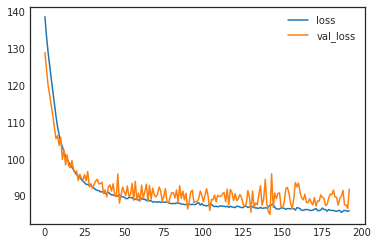

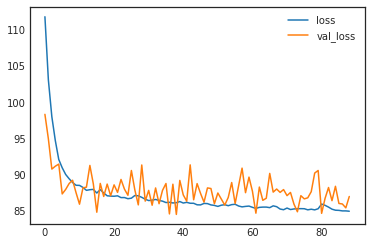

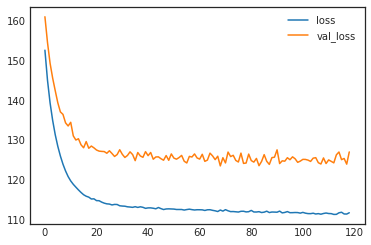

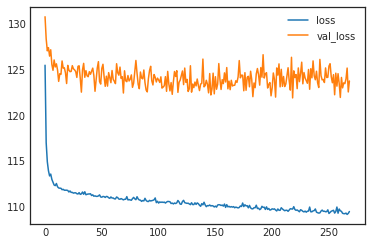

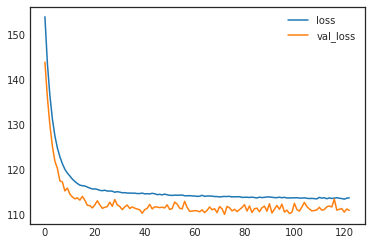

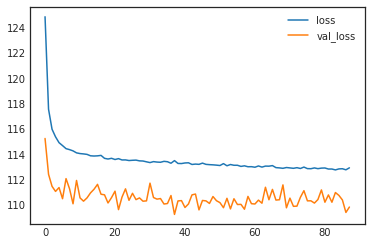

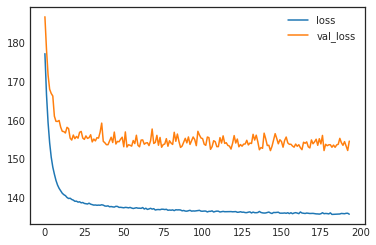

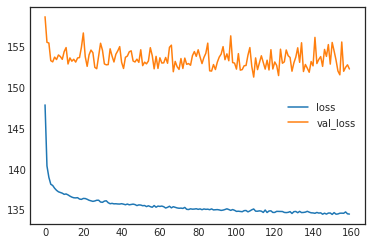

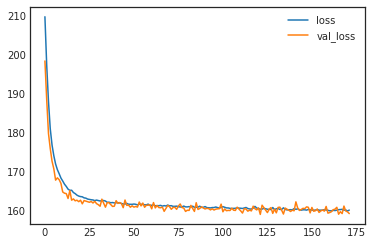

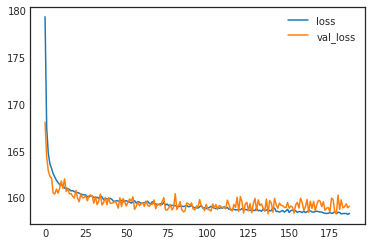

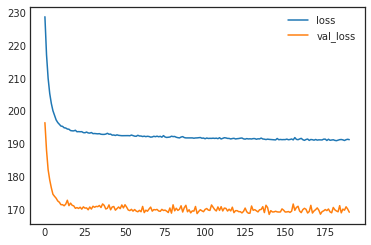

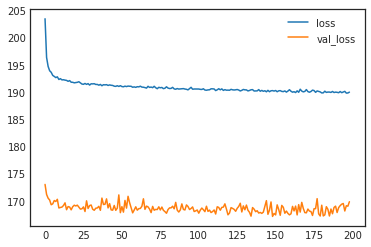

In [5]:
#min_prd_list = range(100, 676, 25)
# min_prd_list = [100, 160, 220, 280, 340, 400, 455, 510, 565, 620, 655]
min_prd_list = [100, 160, 220, 280, 340, 400]
#min_prd = min_prd_list[0]
windows_width = 3*12
cv_xgb_regularizer=0.2
optuna_xgb_trials = 50
optuna_nn_trials = 100

time0 = time.time()

results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test',
                                  'nn4_train', 'nn4_val', 'nn4_test',
                                 'nn6_train', 'nn6_val', 'nn6_test',
                                 'nn4opt_train', 'nn4opt_val', 'nn4opt_test',
                                 'nn6opt_train', 'nn6opt_val', 'nn6opt_test'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:

    with open('../input/mleap-46-preprocessed/MLEAP_46_v7.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+10))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    #display(df.shape, df.head(), df.year.describe(), df.count())

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    temp_cols = ['PERMNO', 'year', 'prd']
    df.reset_index(inplace=True, drop=True)
    X = df.copy()
    y = X.pop('RET')

    train_indx = X.prd<(min_prd+windows_width-1)
    val_indx = X['prd'].isin(range(min_prd+windows_width-1, min_prd+windows_width+2))
    val_indx_extra = X['prd'].isin(range(min_prd+windows_width+5, min_prd+windows_width+8))
    test_indx = X['prd'].isin(range(min_prd+windows_width+2, min_prd+windows_width+5))

    X_train = X[train_indx]
    X_val = X[val_indx]
    X_val_extra = X[val_indx_extra]
    X_test = X[test_indx]
    y_train = y[train_indx]
    y_val = y[val_indx]
    y_val_extra = y[val_indx_extra]
    y_test = y[test_indx]

    #display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
    #display(X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())
    display(X_train.shape, X_val.shape, X_test.shape)

    X_train.drop(columns=temp_cols, inplace=True)
    X_val.drop(columns=temp_cols, inplace=True)
    X_val_extra.drop(columns=temp_cols, inplace=True)
    X_test.drop(columns=temp_cols, inplace=True)

    #display(X_train.tail())
    col_cat = ['ind']
    col_num = [x for x in X_train.columns if x not in col_cat]
    for col in col_num:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_val[col] = X_val[col].fillna(X_train[col].median())
        X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_train[col].median())
    for col in col_cat:
        X_train[col] = X_train[col].fillna(value=-1000)
        X_val[col] = X_val[col].fillna(value=-1000)
        X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
        X_test[col] = X_test[col].fillna(value=-1000)

    #display(X_train.tail())
    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
    X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
    X_train.index = train_index
    X_val.index = val_index
    X_val_extra.index = val_index_extra
    X_test.index = test_index
    #display(X_train.tail())

    X = pd.concat([X_train, X_val])
    y = pd.concat([y_train, y_val])
    #display(X,y)

    X_ = pd.concat([X_train, X_val, X_val_extra])
    y_ = pd.concat([y_train, y_val, y_val_extra])
    #display(X,y, X_,y_)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
    xgb1.fit(X_train, y_train)
    print('fixed XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
    print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
    print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
    [r2_score(y_train, xgb1.predict(X_train)), 
    r2_score(y_val, xgb1.predict(X_val)),
    r2_score(y_test, xgb1.predict(X_test))]

    time1 = time.time()

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 if x in X_train.index else 0 for x in X.index]
    pds = PredefinedSplit(test_fold = split_index)

    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4,5], 'eta':[0.006, 0.012, 0.02], 
                  'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

    # Fit with all data
    xgbgs.fit(X_, y_)

    print('gs XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
    print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
    print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
    [r2_score(y_train, xgbgs.predict(X_train)), 
    r2_score(y_val, xgbgs.predict(X_val)),
    r2_score(y_test, xgbgs.predict(X_test))]

    time1 = time.time()
    def objective_xgb(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 800, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

        model = XGBRegressor(**params, njobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

        score_train = r2_score(y_train, model.predict(X_train))
        score_val = r2_score(y_val, model.predict(X_val))
        score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
        score_val = (score_val+score_val_extra)/2
        overfit = np.abs(score_train-score_val)

        return score_val-cv_xgb_regularizer*overfit


    study = optuna.create_study(direction="maximize")
    study.optimize(objective_xgb, n_trials=optuna_xgb_trials)
    print('Total time for hypermarameter optimization, XGB: ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X, y)
    print('Optuna XGB train: \n', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
          mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
          mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
          mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
    [r2_score(y_train, optuna_xgb.predict(X_train)), 
    r2_score(y_val, optuna_xgb.predict(X_val)),
    r2_score(y_test, optuna_xgb.predict(X_test))]
    
    ###########
    ### NNs ###
    ###########
    
    neurons_base = 8
    l2_reg_rate = 0.5

    model_snn6 = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    print(model_snn6.count_params())

    early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
    optimizer_adam = tf.keras.optimizers.Adam()

    model_snn6.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])

    time1 = time.time()
    history = model_snn6.fit(X_train, y_train, validation_data=(X_val, y_val), 
                             batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

    results.loc[results.min_prd==min_prd,'nn6_train':'nn6_test'] = \
    [r2_score(y_train, model_snn6.predict(X_train)), 
    r2_score(y_val, model_snn6.predict(X_val)),
    r2_score(y_test, model_snn6.predict(X_test))]
    
    
    
    neurons_base = 8
    l2_reg_rate = 0.3

    model_snn4 = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    print(model_snn4.count_params())

    time1 = time.time()
    model_snn4.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    history = model_snn4.fit(X_train, y_train, validation_data=(X_val, y_val), 
                             batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

    results.loc[results.min_prd==min_prd,'nn4_train':'nn4_test'] = \
    [r2_score(y_train, model_snn4.predict(X_train)), 
    r2_score(y_val, model_snn4.predict(X_val)),
    r2_score(y_test, model_snn4.predict(X_test))]
    
    
    
    # try optuna, using this kaggle notebook: https://www.kaggle.com/code/mistag/keras-model-tuning-with-optuna

    time1 = time.time()
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.HyperbandPruner())
    study.optimize(objective_nn4, n_trials=optuna_nn_trials)
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    temp = study.best_params
    display('Optuna NN4', study.best_params, time.time()-time1)

    optimal_hyperpars = list(temp.values())
    display(optimal_hyperpars)
    print('Time for hyperparameter optimization: ',time.time()-time1, optimal_hyperpars)

    optuna_nn = create_snnn4_model_hyperpars(neurons_base=optimal_hyperpars[0], 
                                             l2_reg_rate=optimal_hyperpars[1],
                                            l1_reg_rate=optimal_hyperpars[2])
    history = optuna_nn.fit(X_train, y_train, 
                            validation_data=(X_val, y_val),
                            batch_size=2048, 
                            epochs=1000,
                            verbose=0, 
                            callbacks=[early_stopping50])

    results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
    [r2_score(y_train, optuna_nn.predict(X_train)), 
    r2_score(y_val, optuna_nn.predict(X_val)),
    r2_score(y_test, optuna_nn.predict(X_test))]
    
    
    time1 = time.time()
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.HyperbandPruner())
    study.optimize(objective_nn6, n_trials=optuna_nn_trials)
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    temp = study.best_params
    display('Optuna NN6', study.best_params, time.time()-time1)

    optimal_hyperpars = list(temp.values())
    display(optimal_hyperpars)
    print('Time for hyperparameter optimization: ', time.time()-time1, optimal_hyperpars)

    optuna_nn = create_snnn6_model_hyperpars(neurons_base=optimal_hyperpars[0], 
                                             l2_reg_rate=optimal_hyperpars[1],
                                            l1_reg_rate=optimal_hyperpars[2])
    history = optuna_nn.fit(X_train, y_train, 
                            validation_data=(X_val, y_val),
                            batch_size=2048, 
                            epochs=1000,
                            verbose=0, 
                            callbacks=[early_stopping50])

    results.loc[results.min_prd==min_prd,'nn6opt_train':'nn6opt_test'] = \
    [r2_score(y_train, optuna_nn.predict(X_train)), 
    r2_score(y_val, optuna_nn.predict(X_val)),
    r2_score(y_test, optuna_nn.predict(X_test))]
    
    
    
    display(results)
    
    results.to_csv('temp_models_reg005_1')
    
display(results)

In [6]:
temp

{'neurons_base': 8,
 'l2_regularizer': 0.7239630233038187,
 'l1_regularizer': 0.020066582434692337}

In [7]:
study.best_params

{'neurons_base': 8,
 'l2_regularizer': 0.7239630233038187,
 'l1_regularizer': 0.020066582434692337}

In [8]:
list(study.best_params.values())[1]

0.7239630233038187

In [9]:
display(results.iloc[:,1:].mean())
# cv_regularizer = 0.5
# optuna_trials = 80
print(time.time()-time0)

xgbf_train      0.100558
xgbf_val        0.047035
xgbf_test       0.030342
xgbgs_train     0.108857
xgbgs_val       0.104681
xgbgs_test      0.042327
xgbo_train      0.089201
xgbo_val        0.084902
xgbo_test       0.043828
nn4_train       0.077829
nn4_val         0.057024
nn4_test        0.027747
nn6_train       0.078205
nn6_val         0.059764
nn6_test        0.037620
nn4opt_train    0.071400
nn4opt_val      0.051740
nn4opt_test     0.030455
nn6opt_train    0.033291
nn6opt_val      0.032047
nn6opt_test     0.029951
dtype: float64

9192.17655825615


In [10]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [11]:
print('total time for the script: ', time.time()-time0)
display(results)

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.154493,0.067052,0.006562,0.163225,0.05456,-0.020707,0.16998,0.071151,-0.003824,0.14052,0.043896,-0.003514,-0.0,-0.000982,-0.000893
1,160,0.092879,0.059218,0.019307,0.083546,0.104124,0.00178,0.123592,0.16626,0.019884,0.059241,0.073432,-0.002347,0.058521,0.07053,0.011772,0.064734,0.067478,-0.001783,0.064768,0.069381,0.013801
2,220,0.069412,0.033529,0.050884,0.096305,0.09019,0.069395,0.057841,0.054417,0.061745,0.046731,0.043672,0.056247,0.049514,0.04487,0.057143,0.04458,0.041161,0.058638,0.053382,0.041128,0.058172
3,280,0.071701,0.055032,0.068007,0.096077,0.144013,0.10152,0.07295,0.105004,0.09832,0.056623,0.061293,0.082146,0.052749,0.062193,0.096173,0.045082,0.054403,0.078409,0.048187,0.058234,0.082699
4,340,0.113126,0.075008,0.028664,0.13539,0.131405,0.036136,0.081717,0.075726,0.046317,0.104774,0.080631,0.029349,0.102261,0.083866,0.032296,0.093015,0.076023,0.024823,-0.000001,-0.000001,-0.000007
5,400,0.052553,0.023541,0.02654,0.04468,0.044404,0.029457,0.044615,0.040953,0.030141,0.036379,0.028557,0.021795,0.036204,0.025977,0.032157,0.040469,0.027481,0.026157,0.033411,0.024521,0.025936


In [12]:
 
# def objective_nn(trial):
    
#     tf.keras.backend.clear_session()
    
#     with strategy.scope():
#         # Generate our trial model.
#         model = create_snnn_model(trial)

#         callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=40),
#         TFKerasPruningCallback(trial, "val_loss"),
#     ]

#         # Fit the model on the training data.
#         # The TFKerasPruningCallback checks for pruning condition every epoch.
        
#         history = model.fit(X_train, y_train, 
#                                 validation_data=(X_val, y_val),
#                                 batch_size=2048, 
#                                 epochs=500, 
#                                 verbose=1, 
#                                 callbacks=callbacks)

#         # Evaluate the model accuracy on the validation set.
#         score = model.evaluate(X_val, y_val, verbose=0)
#         return score[1]

# trials = 50

# study = optuna.create_study(direction="minimize", 
#                             sampler=optuna.samplers.TPESampler(), 
#                             pruner=optuna.pruners.HyperbandPruner())
# study.optimize(objective_nn, n_trials=trials)
# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
# temp = study.best_params
# display(study.best_params, time.time()-time1)

# optimal_hyperpars = list(temp.values())
# display(optimal_hyperpars)
# print(time.time()-time1, optimal_hyperpars)

# optuna_nn = create_snnn_model_hyperpars(neurons_base=optimal_hyperpars[0], l2_reg_rate=optimal_hyperpars[1])
# history = optuna_nn.fit(X_train, y_train, 
#                         validation_data=(X_val, y_val),
#                         batch_size=2048, 
#                         epochs=1000,
#                         verbose=1, 
#                         callbacks=[early_stopping50])

# results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
# [r2_score(y_train, optuna_nn.predict(X_train)), 
# r2_score(y_val, optuna_nn.predict(X_val)),
# r2_score(y_test, optuna_nn.predict(X_test))]

In [13]:
results.to_csv('temp_models_1')

In [14]:
# # try optuna for NN:

# def objective(trial):

#     n_layers = trial.suggest_int('n_layers', 1, 3)
#     model = tf.keras.Sequential()
#     for i in range(n_layers):
#         num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
#         model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
#     model.add(tf.keras.layers.Dense(1))
#     display(model.summary())
#     return accuracy

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)


In [ ]:
# on nns:
# - try classic regularizers (l1, l2 etc)
# - try different architecture (not snnn)
# classic architecture:
# He initialization, elu activation, batch norm, l2 reg, adam.

# - try exotic architecture, e.g., wide'n'deep
# 


In [ ]:
# usually self-norm seems better: it overfits less and runs faster

